# Hamiltonian NN (HNN) in (q, p) space

- Original code for (q, v) space from Y. Chen

- Modified and adapted to (q, p) space by Jae Hoon (Daniel) Lee

In [1]:
import torch
import numpy as np
import scipy.integrate
from numpy import sin, cos
import matplotlib.pyplot as plt
import random
solver = scipy.integrate.solve_ivp

seed = 36
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
torch.backends.cudnn.determinstic = True


In [2]:
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
import pandas as pd

BATCH_size = 1000

dftarget = pd.read_csv("./data/hnn_target_dp_qp_sep_sc.csv", header=None, dtype=np.float32)
dfinput = pd.read_csv("./data/hnn_input_dp_qp_sep_sc.csv", header=None, dtype=np.float32)

X_train, X_test, Y_train, Y_test = train_test_split(dfinput.values, dftarget.values, test_size=0.2)

# train data
data_train = data_utils.TensorDataset(torch.tensor(X_train), torch.tensor(Y_train))
train_loader = torch.utils.data.DataLoader(data_train, batch_size=BATCH_size, shuffle=True)

# test data
data_test = data_utils.TensorDataset(torch.tensor(X_test), torch.tensor(Y_test))
test_loader = torch.utils.data.DataLoader(data_test, batch_size=BATCH_size, shuffle=True)

In [3]:
import torch.nn as nn
import torch.optim as optim
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#!nvidia-smi


In [4]:
N = 2
O = np.zeros((N,N))
Id = np.eye(N)
S = np.vstack([np.hstack([O,Id]),np.hstack([-Id,O])])
St = torch.tensor(-S, dtype=torch.float32).to(device)
class MLP(nn.Module):
  def __init__(self,input_size,hidden_size,output_size):
    super(MLP,self).__init__()
    self.l1 = nn.Linear(input_size,hidden_size)
    self.l2 = nn.Linear(hidden_size,hidden_size)
    self.l3 = nn.Linear(hidden_size,output_size)
  
  def forward(self,x):
    x = self.l1(x)
    x = torch.tanh(x)
    x = self.l2(x)
    x = torch.tanh(x)
    x = self.l3(x)
    return x

  def grad(self,x):
    x = x.requires_grad_(True)
    with torch.enable_grad():
      hamiltonian = self(x)
      gradient = torch.autograd.grad(hamiltonian.sum(),x,create_graph=True,retain_graph=True)
    return torch.matmul(gradient[0],St)

  def fvec(self,t,x):
    return self.grad(x)

In [5]:
import time
input_size = 4
output_size = 1
hidden_size = 200
num_trials = 10
stats = {'train_loss': [], 'eval_loss': [], 'computation_time': []}

for trial in range(num_trials):
  mynet = MLP(input_size,hidden_size,output_size).to(device)
  num_epochs = 2000

  criterion = nn.MSELoss()

  optimizer = optim.Adam(params=mynet.parameters(),lr=1e-4) #0.001)

  history_loss = []
  history_eval = []
  history_acc = []

  cnt = 0
  startt = time.time()
  for epoch in range(num_epochs):
    mynet.train()

    total_loss = 0.0
    eval_loss = 0.0
    cnt = 0
    for i,(data,target) in enumerate(train_loader):
      optimizer.zero_grad()
      output = mynet.grad(data.to(device))

      loss = criterion(output,target.to(device))
      loss.backward()
      optimizer.step()

      total_loss = total_loss+loss.cpu().item()
      cnt = cnt + 1
    total_loss = total_loss/cnt

    num_correct = 0
    num_data = 0
    mynet.eval()
    eval_loss = 0.0
    cnt = 0
    for i,(data,target) in enumerate(test_loader):
      output = mynet.grad(data.to(device))
      eval_loss = eval_loss+criterion(output,target.to(device)).cpu().item()
      cnt = cnt + 1
    eval_loss = eval_loss/cnt
  
    history_loss.append(total_loss)
    history_eval.append(eval_loss)

    if total_loss == np.min(history_loss):
      min_total_loss_in_tl = total_loss
      min_evaluation_loss_in_tl = eval_loss
      min_train_index = epoch+1

    if eval_loss == np.min(history_eval):
      min_evalation_loss_in_el = eval_loss
      min_total_loss_in_el = total_loss
      min_evaluation_index = epoch+1
      path = "./model/danieljh_hnn_dp_qp_sep_sc_2t_lr_{}".format(trial)
      torch.save(mynet.state_dict(), path)
  
  print("{}/{} training loss:{},evaluation loss:{}".format(epoch+1,num_epochs,total_loss,eval_loss))
  stats['train_loss'].append(total_loss)
  stats['eval_loss'].append(eval_loss)
  stats['computation_time'].append(time.time() - startt)

print("train_loss:{}, std: {}".format(np.mean(stats['train_loss']), np.std(stats['train_loss'])))
print("test_loss:{}, std: {}".format(np.mean(stats['eval_loss']), np.std(stats['eval_loss'])))
print("computation_time:{}, std: {}".format(np.mean(stats['computation_time']), np.std(stats['computation_time'])))


2000/2000 training loss:0.002760510193184018,evaluation loss:0.0027837335248477755
2000/2000 training loss:0.0028281145918299445,evaluation loss:0.002872613683575764
2000/2000 training loss:0.00268205738539109,evaluation loss:0.0027134599804412574
2000/2000 training loss:0.002750214449770283,evaluation loss:0.0027704086503945293
2000/2000 training loss:0.0027686567860655486,evaluation loss:0.0027959837869275363
2000/2000 training loss:0.0027485483078635298,evaluation loss:0.0027664380031637847
2000/2000 training loss:0.002686043520225212,evaluation loss:0.002700249489862472
2000/2000 training loss:0.0028221469736308792,evaluation loss:0.0028563986415974796
2000/2000 training loss:0.0026654479675926267,evaluation loss:0.002681069722166285
2000/2000 training loss:0.0028320638550212605,evaluation loss:0.0028665860067121685
train_loss:0.0027543804030574393, std: 5.845172525038693e-05
test_loss:0.0027806941489689056, std: 6.559468369766324e-05
computation_time:1580.2944517612457, std: 19.48

In [6]:
import pandas as pd
A = pd.read_csv("./data/hnn_A_dp_qp_sep_sc.csv", header=None, dtype=np.float32)
B = pd.read_csv("./data/hnn_B_dp_qp_sep_sc.csv", header=None, dtype=np.float32)
A = np.asmatrix(A)
B = np.asmatrix(B)

In [ ]:
def mass_matrix(q1, q2, m1, m2, l1, l2):
    """ 
    M(q) matrix is computed. q1, q2: (M,)
    return shape: (M, 2, 2)
    """
    # Check if q1, q2 are numpy arrays
    if isinstance(q1, (int, float)):
        q1 = np.array([q1])
        q2 = np.array([q2])
        is_scalar = True
    else:
        is_scalar = False

    cos12 = np.cos(q1 - q2)

    M11 = (m1 + m2) * l1**2
    M12 = m2 * l1 * l2 * cos12
    M22 = m2 * l2**2

    # (M, 2, 2) shape
    M_q = np.zeros((q1.shape[0], 2, 2))
    M_q[:, 0, 0] = M11
    M_q[:, 0, 1] = M12
    M_q[:, 1, 0] = M12 
    M_q[:, 1, 1] = M22
    
    # If input is scalar, return (2, 2) matrix
    if is_scalar:
        return M_q[0]
    else:
        return M_q


In [ ]:
def compute_hamiltonian(q1, q2, p1, p2, m1, m2, l1, l2, g):
    """
    With (q, p) state vector input, Hamiltonian H(q, p) is computed.
    Inputs have to be all same length numpy arrays.
    """
    # 1. Potential Energy V(q) computation
    V = -g * (m1 + m2) * l1 * np.cos(q1) - g * m2 * l2 * np.cos(q2)
    
    # 2. For Kinetic Energy T(q, v) computation, we first convert p to v.
    M_q = mass_matrix(q1, q2, m1, m2, l1, l2) # (M, 2, 2)
    p_vec = np.vstack([p1, p2]).T             # (M, 2)

    # p = M * v --> v = inv(M) * p
    inv_M = np.linalg.inv(M_q) # (M, 2, 2)
    v_vec = np.einsum('Nij, Nj->Ni', inv_M, p_vec) # (M, 2)
    
    # Kinetic Energy T computation: T = 0.5 * v^T * M * v 
    # M * v computation -> (M, 2)
    Mv = np.einsum('Nij, Nj->Ni', M_q, v_vec)
        
    # v^T * (M * v) computation -> (M,) (inner product)
    vT_Mv = np.einsum('Ni, Ni->N', v_vec, Mv)

    T = 0.5 * vT_Mv

    H = T + V
    return H

HNN x0 (q, p): (0.01825532, 0.52412613, np.float64(1.3729138566146588), np.float64(1.003508379581577))
(0.01825532, 0.52412613, np.float64(1.3729138566146588), np.float64(1.003508379581577))


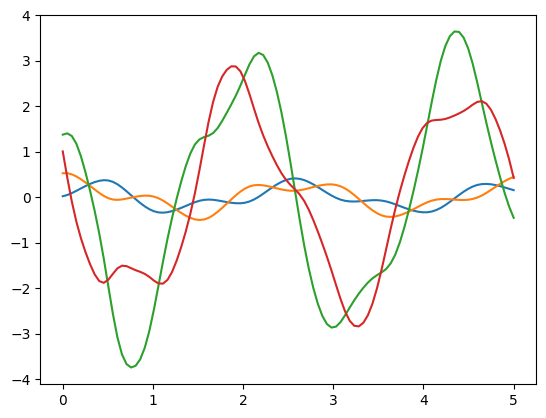

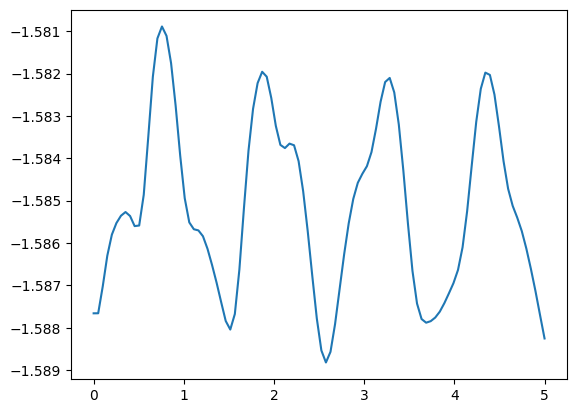

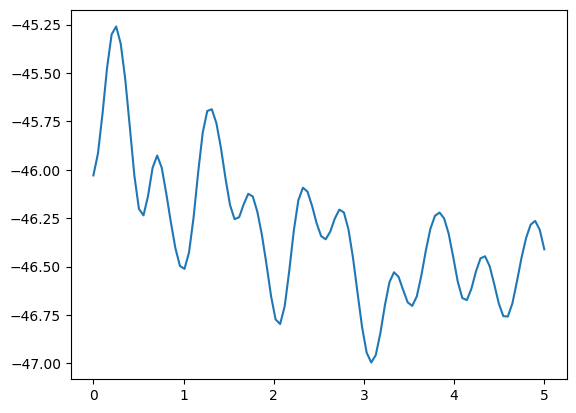

energy shape: (100,)


In [ ]:
# simulation
# parameters
g = 9.8
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0
m = m1+m2

def compute_momentum(q1, v1, q2, v2, m1, m2, l1, l2):
    cos_q1q2 = np.cos(q1 - q2)
    p1 = (m1 + m2) * l1**2 * v1 + m2 * l1 * l2 * v2 * cos_q1q2
    p2 = m2 * l2**2 * v2 + m2 * l1 * l2 * v1 * cos_q1q2
    return p1, p2
# -----------------------------------------------------------

trial = num_trials - 1

input_size = 4
output_size = 1
hidden_size = 200
mynet = MLP(input_size,hidden_size,output_size).to('cpu')
mynet.load_state_dict(torch.load("./model/danieljh_hnn_dp_qp_sep_sc_2t_lr_{}".format(trial), map_location="cpu"))
mynet.eval()

teval = torch.linspace(0.0,5.0,100)

# Initial value (q1, q2, v1, v2 order) from the original Y. Chen's train code.
# state_init = []
# for i in range(1):
#   s = (0.01825532, 0.52412613, 0.33688556, 0.20706259 )
#   state_init.append(s)

# --- x0 conversion: (q1, q2, v1, v2) -> (q1, q2, p1, p2) ---
q1_0, q2_0, v1_0, v2_0 = (0.01825532, 0.52412613, 0.33688556, 0.20706259)
p1_0, p2_0 = compute_momentum(q1_0, v1_0, q2_0, v2_0, m1, m2, l1, l2)
x0 = (q1_0, q2_0, p1_0, p2_0) # adapted to HNN's (q, p) input
print(f"HNN x0 (q, p): {x0}")
# -----------------------------------------------------

print(x0)
dt = teval[1]-teval[0]
St = torch.tensor(-S, dtype=torch.float32)
teval = teval.detach().cpu().numpy()
A = torch.tensor(A, dtype=torch.float32)
B = torch.tensor(B, dtype=torch.float32)
mynet.eval()
mynet.cpu()
def fvec_np(x,t):
  tx = torch.tensor(x, dtype=torch.float)
  x = torch.matmul(tx, torch.inverse(B))
  output = mynet.grad(x).squeeze(0)
  output = torch.matmul(A, output)
  output = output.squeeze(0)    
  return output.detach().cpu().numpy()

res = scipy.integrate.odeint(fvec_np,x0,teval)

ax=plt.subplot()
# ax.set_ylim([-3,3])
ax.plot(teval,res[:,0])
ax.plot(teval,res[:,1])
ax.plot(teval,res[:,2])
ax.plot(teval,res[:,3])
  
plt.show()

def net_energy(x,t):
  tx = torch.tensor(x, dtype=torch.float)
  x = torch.matmul(tx, torch.inverse(B))
  ne = mynet.forward(x).squeeze(0)
  return ne.detach().cpu().numpy()

net_energy = net_energy(res, teval).reshape((100))
plt.plot(teval,net_energy)
plt.show()
   
q1 = res[:, 0]
q2 = res[:, 1]
p1 = res[:, 2]
p2 = res[:, 3]

# Computed H(q,p) values (Energy with respect to time)
energy = compute_hamiltonian(q1, q2, p1, p2, m1, m2, l1, l2, g)
plt.plot(teval, energy)
plt.show()

print('energy shape:', energy.shape)

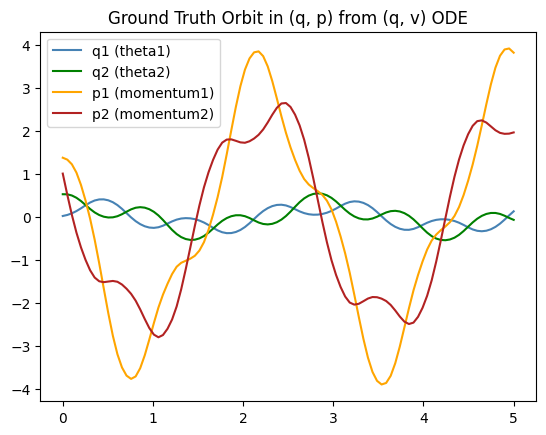

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp as solver 

# double pendulum ground truth (q, p) orbit creation code
# parameters
g = 9.8
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0
m = m1+m2

def compute_momentum(q1, v1, q2, v2, m1, m2, l1, l2):
    cos_q1q2 = np.cos(q1 - q2)
    p1 = (m1 + m2) * l1**2 * v1 + m2 * l1 * l2 * v2 * cos_q1q2
    p2 = m2 * l2**2 * v2 + m2 * l1 * l2 * v1 * cos_q1q2
    return p1, p2
# ------------------------------------------------

# equations of motion (q, v space)
def func(t, state):
  """
  ODE of the double-pendulum system (q, v space)
  state = [q1, q2, v1, v2]
  dvdt = [v1, v2, a1, a2]
  """
  cosv = np.cos(state[0]-state[1])
  sinv = np.sin(state[0]-state[1])
  dvdt = np.zeros_like(state)
  
  # dq/dt = v
  dvdt[0] = state[2] # v1
  dvdt[1] = state[3] # v2
  
  # dv/dt = a (acceleration computation)
  # a1
  dvdt[2] = (g*(np.sin(state[1])*cosv - m/m2*np.sin(state[0])) - (l1*state[2]*state[2]*cosv + l2* state[3]*state[3])*sinv) / (l1*(m/m2-cosv*cosv))
  # a2
  dvdt[3] = (g*m/m2*(np.sin(state[0])*cosv - np.sin(state[1])) + sinv * (l1*state[2]*state[2]*m/m2 + l2* state[3]*state[3]*cosv)) / (l2*(m/m2-cosv*cosv))
  
  return dvdt

#　the time grid
M = 100
tend = 5.0
t_eval = np.linspace(0,tend,M)
dt = t_eval-t_eval

# initila values (q1, q2, v1, v2 order)
state_init = []
for i in range(1):
  s = (0.01825532, 0.52412613, 0.33688556, 0.20706259 )
  state_init.append(s)

# trajectory computation
for i in range(1):
  sol = solver(func, [0, tend], state_init[i], t_eval=t_eval)
  tval = sol['t']
  
# (q, v) trajectory
q1 = sol['y'][0, :]
q2 = sol['y'][1, :]
v1 = sol['y'][2, :]
v2 = sol['y'][3, :]

true_x_qv = sol['y'].T # (M, 4) [q1, q2, v1, v2]
  
# For HNN, coverted to (q, p) trajectory
p1, p2 = compute_momentum(q1, v1, q2, v2, m1, m2, l1, l2)

true_x_qv2qp = np.vstack([q1, q2, p1, p2]).T  # (M, 4) [q1, q2, p1, p2]
  
# plot in (q, p)
plt.title("Ground Truth Orbit in (q, p) from (q, v) ODE")
ax=plt.subplot()
#ax.set_ylim([-3,3])
ax.plot(tval, true_x_qv2qp[:,0], 'steelblue', label='q1 (theta1)')
ax.plot(tval, true_x_qv2qp[:,1], 'g', label='q2 (theta2)')
ax.plot(tval, true_x_qv2qp[:,2], 'orange', label='p1 (momentum1)')
ax.plot(tval, true_x_qv2qp[:,3], 'firebrick', label='p2 (momentum2)')
ax.legend()
plt.show()


In [ ]:
def mass_matrix(q1, q2, m1, m2, l1, l2):
    """ 
    M(q) matrix is computed. q1, q2 can be scalar or numpy arrays.
    return shape: (..., 2, 2) if input is array, (2, 2) if input is scalar. 
    """
    cos12 = np.cos(q1 - q2)
    
    M11 = (m1 + m2) * l1**2
    M12 = m2 * l1 * l2 * cos12
    M22 = m2 * l2**2

    # Initialize M_q upon input shape
    if np.ndim(q1) > 0:
        # case q1: array --> (..., 2, 2)
        M_q = np.zeros(q1.shape + (2, 2))
    else:
        # case q1: scalar --> (2, 2)
        M_q = np.zeros((2, 2))
    
    # Value assignment by broadcasting
    M_q[..., 0, 0] = M11
    M_q[..., 0, 1] = M12
    M_q[..., 1, 0] = M12 # M21 (symmetric)
    M_q[..., 1, 1] = M22
    
    return M_q

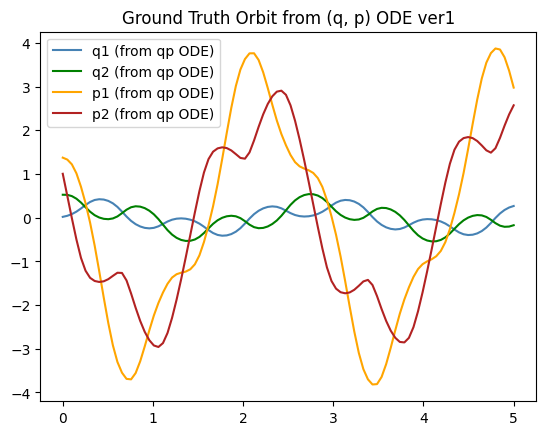

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp as solver

# parameters
g = 9.8
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0
m = m1+m2


def compute_momentum(q1, v1, q2, v2, m1, m2, l1, l2):
    cos_q1q2 = np.cos(q1 - q2)
    p1 = (m1 + m2) * l1**2 * v1 + m2 * l1 * l2 * v2 * cos_q1q2
    p2 = m2 * l2**2 * v2 + m2 * l1 * l2 * v1 * cos_q1q2
    return p1, p2
# ------------------------------------------------

# (q, v) space func (used inside func_qp below)
def func_qv(t, state):
  cosv = np.cos(state[0]-state[1])
  sinv = np.sin(state[0]-state[1])
  dvdt = np.zeros_like(state)
  dvdt[0] = state[2]
  dvdt[1] = state[3]
  dvdt[2] = (g*(np.sin(state[1])*cosv - m/m2*np.sin(state[0])) - (l1*state[2]*state[2]*cosv + l2* state[3]*state[3])*sinv) / (l1*(m/m2-cosv*cosv))
  dvdt[3] = (g*m/m2*(np.sin(state[0])*cosv - np.sin(state[1])) + sinv * (l1*state[2]*state[2]*m/m2 + l2* state[3]*state[3]*cosv)) / (l2*(m/m2-cosv*cosv))
  return dvdt

# equations of motion (q, p space - Hamiltonian mechanics)
def func_qp_ver1(t, state_qp):
    """
    ODE of the double-pendulum system (q, p space)
    state_qp = [q1, q2, p1, p2]
    return value: [dq1/dt, dq2/dt, dp1/dt, dp2/dt]
    """
    q1, q2, p1, p2 = state_qp
    
    # 1. dq/dt = inv(M) * p (Velocity v computation)
    M_q = mass_matrix(q1, q2, m1, m2, l1, l2) # (2, 2)
    inv_M = np.linalg.inv(M_q) # (2, 2)
    p_vec = np.array([p1, p2]) # (2,)
    v_vec = np.dot(inv_M, p_vec) # (2,) -> [v1, v2]

    v1, v2 = v_vec
    
    # 2. dp/dt = -dH/dq (Use ∂L/∂q part of the Euler-Lagrange equations)
    # exact expression for dp/dt
    sin12 = np.sin(q1 - q2)
    dp1_dt = -(m1 + m2) * g * l1 * np.sin(q1) - m2 * l1 * l2 * v1 * v2 * sin12
    dp2_dt = -m2 * g * l2 * np.sin(q2) + m2 * l1 * l2 * v1**2 * sin12

    # -----------------------------------------------------------

    return np.array([v1, v2, dp1_dt, dp2_dt])



#　the time grid
M = 100
tend = 5.0
t_eval = np.linspace(0,tend,M)

# convert initial values: (q1, q2, v1, v2) -> (q1, q2, p1, p2)
q1_0, q2_0, v1_0, v2_0 = (0.01825532, 0.52412613, 0.33688556, 0.20706259)
p1_0, p2_0 = compute_momentum(q1_0, v1_0, q2_0, v2_0, m1, m2, l1, l2)
x0_qp = np.array([q1_0, q2_0, p1_0, p2_0])

# Orbit compuation (Use q, p space ODE)
sol_qp = solver(func_qp_ver1, [0, tend], x0_qp, t_eval=t_eval)
tval_qp = sol_qp['t']
true_x_qp_ver1 = sol_qp['y'].T # (M, 4) [q1, q2, p1, p2]

# plot in (q, p)
ax=plt.subplot()
ax.plot(tval_qp, true_x_qp_ver1[:, 0], 'steelblue', label='q1 (from qp ODE)')
ax.plot(tval_qp, true_x_qp_ver1[:, 1], 'g', label='q2 (from qp ODE)')
ax.plot(tval_qp, true_x_qp_ver1[:, 2], 'orange', label='p1 (from qp ODE)')
ax.plot(tval_qp, true_x_qp_ver1[:, 3], 'firebrick', label='p2 (from qp ODE)')
ax.legend()
plt.title("Ground Truth Orbit from (q, p) ODE ver1")
plt.show()

In [ ]:
def mass_matrix_scalar(q1, q2, m1, m2, l1, l2):
    """ 
    M(q) matrix is computed solely for scalar input.
    return shape: (2, 2)
    """
    cos12 = np.cos(q1 - q2)
    
    M11 = (m1 + m2) * l1**2
    M12 = m2 * l1 * l2 * cos12
    M22 = m2 * l2**2
    
    return np.array([[M11, M12], [M12, M22]]) # (2, 2)

def mass_matrix_dot_scalar(q1, v1, q2, v2, m1, m2, l1, l2):
    """
    Computes, the time-derivative of mass-matrix M(q), M_dot(q, v) (for scalar input).
    v1, v2 are time-derivatives of q1, q2 (angular velocity).
    return shape: (2, 2)
    """
    sin12 = np.sin(q1 - q2)
    
    delta_v = v1 - v2

    M_dot11 = 0.0 # M11 is a constant.
    M_dot12 = -m2 * l1 * l2 * sin12 * delta_v
    M_dot22 = 0.0 # M22 is a constant.

    return np.array([[M_dot11, M_dot12], [M_dot12, M_dot22]]) # (2, 2)

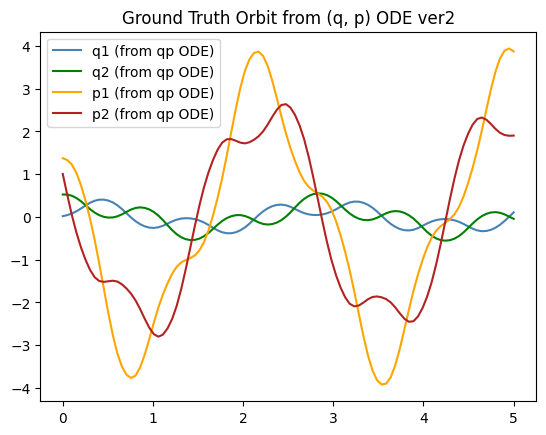

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp as solver

# parameters
g = 9.8
m1 = 1.0
m2 = 2.0
l1 = 1.0
l2 = 1.0
m = m1+m2

def compute_momentum(q1, v1, q2, v2, m1, m2, l1, l2):
    cos_q1q2 = np.cos(q1 - q2)
    p1 = (m1 + m2) * l1**2 * v1 + m2 * l1 * l2 * v2 * cos_q1q2
    p2 = m2 * l2**2 * v2 + m2 * l1 * l2 * v1 * cos_q1q2
    return p1, p2

# ------------------------------------------------

# (q, v) space func (used inside func_qp below)
def func_qv(t, state):
  cosv = np.cos(state[0]-state[1])
  sinv = np.sin(state[0]-state[1])
  dvdt = np.zeros_like(state)
  dvdt[0] = state[2]
  dvdt[1] = state[3]
  dvdt[2] = (g*(np.sin(state[1])*cosv - m/m2*np.sin(state[0])) - (l1*state[2]*state[2]*cosv + l2* state[3]*state[3])*sinv) / (l1*(m/m2-cosv*cosv))
  dvdt[3] = (g*m/m2*(np.sin(state[0])*cosv - np.sin(state[1])) + sinv * (l1*state[2]*state[2]*m/m2 + l2* state[3]*state[3]*cosv)) / (l2*(m/m2-cosv*cosv))
  return dvdt

# ------------------------------------------------

# equations of motion (q, p space - Hamiltonian Mechanics)
def func_qp_ver2(t, state_qp):
    """
    ODE of the double-pendulum system (q, p space)
    state_qp = [q1, q2, p1, p2]
    return value: [dq1/dt, dq2/dt, dp1/dt, dp2/dt]
    """
    q1, q2, p1, p2 = state_qp
    
    # 1. dq/dt = inv(M) * p 계산 (Velocity v computation)
    M_q = mass_matrix_scalar(q1, q2, m1, m2, l1, l2)
    inv_M = np.linalg.inv(M_q)
    p_vec = np.array([p1, p2])
    v_vec = np.dot(inv_M, p_vec) # [v1, v2] 반환

    v1, v2 = v_vec
    
    # 2. Using the formula, dp/dt = M*a + M_dot*v, compute dp/dt exactly.
    #    For this, we need acceleration 'a' from the return of func_qv(q,v).
    state_qv = np.array([q1, q2, v1, v2]) 
    dxdt_qv = func_qv(t, state_qv) # [v1, v2, a1, a2] is returned
    a1, a2 = dxdt_qv[2], dxdt_qv[3] # accelerations are taken.
    
    M_dot_q = mass_matrix_dot_scalar(q1, v1, q2, v2, m1, m2, l1, l2)
    a_vec = np.array([a1, a2])
    
    # dp_dt_vec = M*a + M_dot*v
    dp_dt_vec = np.dot(M_q, a_vec) + np.dot(M_dot_q, v_vec)
    dp1_dt, dp2_dt = dp_dt_vec

    # [dq1/dt, dq2/dt, dp1/dt, dp2/dt] is returned
    return np.array([v1, v2, dp1_dt, dp2_dt]) 

#　the time grid
M = 100
tend = 5.0
t_eval = np.linspace(0,tend,M)

# Convert initial values: (q1, q2, v1, v2) -> (q1, q2, p1, p2)
q1_0, q2_0, v1_0, v2_0 = (0.01825532, 0.52412613, 0.33688556, 0.20706259)
p1_0, p2_0 = compute_momentum(q1_0, v1_0, q2_0, v2_0, m1, m2, l1, l2)
x0_qp = np.array([q1_0, q2_0, p1_0, p2_0])

# Trajectory computation (Use q, p space ODE)
sol_qp = solver(func_qp_ver2, [0, tend], x0_qp, t_eval=t_eval)
tval_qp = sol_qp['t']
true_x_qp_ver2 = sol_qp['y'].T # (M, 4) [q1, q2, p1, p2]

# plot in (q, p)
ax=plt.subplot()
ax.plot(tval_qp, true_x_qp_ver2[:, 0], 'steelblue', label='q1 (from qp ODE)')
ax.plot(tval_qp, true_x_qp_ver2[:, 1], 'g', label='q2 (from qp ODE)')
ax.plot(tval_qp, true_x_qp_ver2[:, 2], 'orange', label='p1 (from qp ODE)')
ax.plot(tval_qp, true_x_qp_ver2[:, 3], 'firebrick', label='p2 (from qp ODE)')
ax.legend()
plt.title("Ground Truth Orbit from (q, p) ODE ver2")
plt.show()

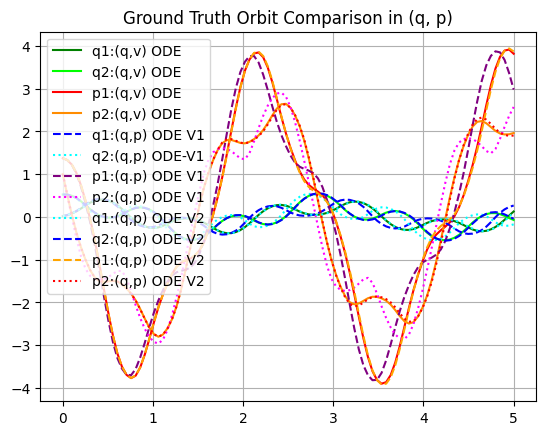

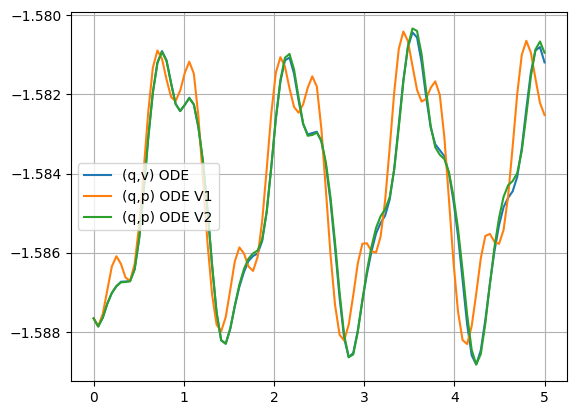

In [ ]:
# Orbit comparison upon which ODE is taken
plt.title("Ground Truth Orbit Comparison in (q, p)")
ax=plt.subplot()
ax.plot(tval_qp, true_x_qv2qp[:, 0], 'green', label='q1:(q,v) ODE')
ax.plot(tval_qp, true_x_qv2qp[:, 1], 'lime', label='q2:(q,v) ODE')
ax.plot(tval_qp, true_x_qv2qp[:, 2], 'red', label='p1:(q,v) ODE') 
ax.plot(tval_qp, true_x_qv2qp[:, 3], 'darkorange', label='p2:(q,v) ODE')
ax.plot(tval_qp, true_x_qp_ver1[:, 0], 'blue', label='q1:(q,p) ODE V1', linestyle='--')
ax.plot(tval_qp, true_x_qp_ver1[:, 1], 'cyan', label='q2:(q,p) ODE-V1', linestyle=':')
ax.plot(tval_qp, true_x_qp_ver1[:, 2], 'purple', label='p1:(q.p) ODE V1', linestyle='--')
ax.plot(tval_qp, true_x_qp_ver1[:, 3], 'magenta', label='p2:(q,p) ODE V1', linestyle=':')
ax.plot(tval_qp, true_x_qp_ver2[:, 0], 'cyan', label='q1:(q,p) ODE V2', linestyle=':')
ax.plot(tval_qp, true_x_qp_ver2[:, 1], 'blue', label='q2:(q,p) ODE V2', linestyle='--')
ax.plot(tval_qp, true_x_qp_ver2[:, 2], 'orange', label='p1:(q,p) ODE V2', linestyle='--')
ax.plot(tval_qp, true_x_qp_ver2[:, 3], 'red', label='p2:(q,p) ODE V2', linestyle=':')
ax.legend()
ax.grid(True)
plt.show()

def net_energy(x,t):
  tx = torch.tensor(x, dtype=torch.float)
  x = torch.matmul(tx, torch.inverse(B))
  ne = mynet.forward(x).squeeze(0)
  return ne.detach().cpu().numpy()

# Energy comparison upon which ODE is taken
hnn_energy_true_x_qp2qv = net_energy(true_x_qv2qp, tval_qp).reshape((100))
hnn_energy_true_x_qp_ver1 = net_energy(true_x_qp_ver1, tval_qp).reshape((100))
hnn_energy_true_x_qp_ver2 = net_energy(true_x_qp_ver2, tval_qp).reshape((100))
plt.plot(tval_qp,hnn_energy_true_x_qp2qv, label='(q,v) ODE')
plt.plot(tval_qp,hnn_energy_true_x_qp_ver1, label='(q,p) ODE V1')
plt.plot(tval_qp,hnn_energy_true_x_qp_ver2, label='(q,p) ODE V2')
plt.legend()
plt.grid(True)
plt.show()

HNN x0 (q, p): (0.01825532, 0.52412613, 0.33688556, 0.41412518)
(0.01825532, 0.52412613, 0.33688556, 0.41412518)


/tmp/ipykernel_269220/1636725138.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  A = torch.tensor(A, dtype=torch.float32)
/tmp/ipykernel_269220/1636725138.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  B = torch.tensor(B, dtype=torch.float32)


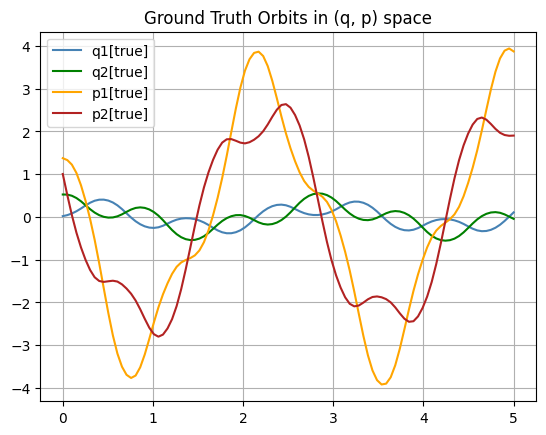

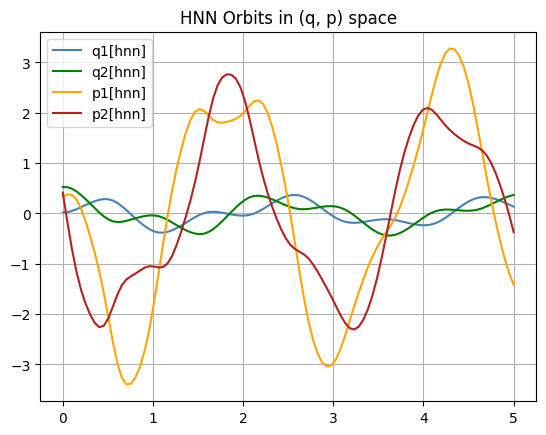

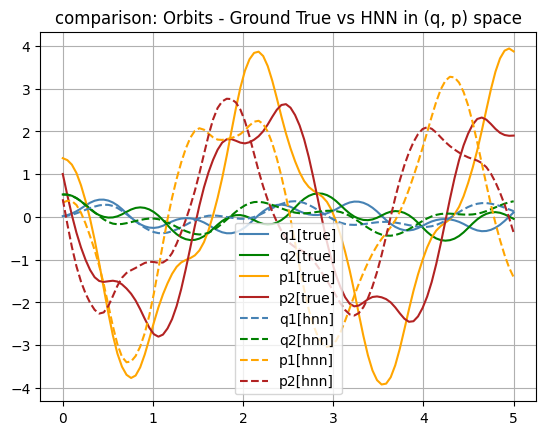

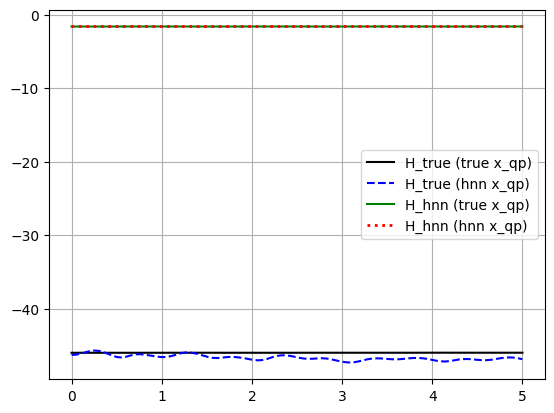

In [ ]:
# --- x0 conversion: (q1, q2, v1, v2) -> (q1, q2, p1, p2) ---
q1_0, q2_0, v1_0, v2_0 = (0.01825532, 0.52412613, 0.33688556, 0.20706259)
p1_0, p2_0 = m1*v1_0, m2*v2_0
x0 = (q1_0, q2_0, p1_0, p2_0) # adapted to HNN's (q, p) input
print(f"HNN x0 (q, p): {x0}")
# -----------------------------------------------------

print(x0)
dt = teval[1]-teval[0]
#St = torch.tensor(-S, dtype=torch.float32)
#teval = teval.detach().cpu().numpy()
A = torch.tensor(A, dtype=torch.float32)
B = torch.tensor(B, dtype=torch.float32)
mynet.eval()
mynet.cpu()

def fvec_np(x,t):
  tx = torch.tensor(x, dtype=torch.float)
  x = torch.matmul(tx, torch.inverse(B))
  output = mynet.grad(x).squeeze(0)
  output = torch.matmul(A, output)
  output = output.squeeze(0)    
  return output.detach().cpu().numpy()

res = scipy.integrate.odeint(fvec_np,x0,teval)

hnn_x_qp = res.copy()
plt.title("Ground Truth Orbits in (q, p) space")
plt.plot(tval, true_x_qp_ver2[:,0], 'steelblue', label='q1[true]', linestyle='-')
plt.plot(tval, true_x_qp_ver2[:,1], 'g', label='q2[true]', linestyle='-')
plt.plot(tval, true_x_qp_ver2[:,2], 'orange', label='p1[true]', linestyle='-')
plt.plot(tval, true_x_qp_ver2[:,3], 'firebrick', label='p2[true]', linestyle='-')
plt.grid(True)
plt.legend()
plt.show()

plt.title("HNN Orbits in (q, p) space")
plt.plot(tval, hnn_x_qp[:,0], 'steelblue', label='q1[hnn]', linestyle='-')
plt.plot(tval, hnn_x_qp[:,1], 'g', label='q2[hnn]', linestyle='-')
plt.plot(tval, hnn_x_qp[:,2], 'orange', label='p1[hnn]', linestyle='-')
plt.plot(tval, hnn_x_qp[:,3], 'firebrick', label='p2[hnn]',linestyle='-')
plt.grid(True)
plt.legend()
plt.show()

plt.title("comparison: Orbits - Ground True vs HNN in (q, p) space")
plt.plot(tval, true_x_qp_ver2[:,0], 'steelblue', label='q1[true]', linestyle='-')
plt.plot(tval, true_x_qp_ver2[:,1], 'g', label='q2[true]', linestyle='-')
plt.plot(tval, true_x_qp_ver2[:,2], 'orange', label='p1[true]', linestyle='-')
plt.plot(tval, true_x_qp_ver2[:,3], 'firebrick', label='p2[true]', linestyle='-')
plt.plot(tval, hnn_x_qp[:,0], 'steelblue', label='q1[hnn]', linestyle='--')
plt.plot(tval, hnn_x_qp[:,1], 'g', label='q2[hnn]', linestyle='--')
plt.plot(tval, hnn_x_qp[:,2], 'orange', label='p1[hnn]', linestyle='--')
plt.plot(tval, hnn_x_qp[:,3], 'firebrick', label='p2[hnn]',linestyle='--')
plt.grid(True)
plt.legend()
plt.show()

def net_energy(x,t):
  tx = torch.tensor(x, dtype=torch.float)
  x = torch.matmul(tx, torch.inverse(B))
  ne = mynet.forward(x).squeeze(0)
  return ne.detach().cpu().numpy()

hnn_energy_hnn_x_qp = net_energy(hnn_x_qp, teval).reshape((100))
hnn_energy_true_x_qp = net_energy(true_x_qp_ver2, teval).reshape((100))
true_energy_hnn_x_qp = compute_hamiltonian(hnn_x_qp[:,0], hnn_x_qp[:,1], hnn_x_qp[:,2], hnn_x_qp[:,3], m1, m2, l1, l2, g)
true_energy_true_x_qp = compute_hamiltonian(true_x_qp_ver2[:,0], true_x_qp_ver2[:,1], true_x_qp_ver2[:,2], true_x_qp_ver2[:,3], m1, m2, l1, l2, g)

plt.plot(teval,true_energy_true_x_qp, label='H_true (true x_qp)', color='k', linestyle='-')
plt.plot(teval,true_energy_hnn_x_qp, label='H_true (hnn x_qp)', color='b',linestyle='--')
plt.plot(teval,hnn_energy_true_x_qp, label='H_hnn (true x_qp)', color='g', linestyle='-', lw=1.5)
plt.plot(teval,hnn_energy_hnn_x_qp, label='H_hnn (hnn x_qp)', color='r', linestyle=':', lw=2)
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
def inv_mass_matrix_scalar(q1, q2, m1, m2, l1, l2):
    """
    Computes analytically M_inv, 
    the inverse matrix of the double-pendulum mass-matrix M.
    Input q1, q2 can be scalars or numpy arays of the identical shape.
    """
    cos12 = np.cos(q1 - q2)
    
    # M matrix elements
    M11 = (m1 + m2) * l1**2
    M12 = m2 * l1 * l2 * cos12
    M22 = m2 * l2**2
    
    # Determinant computation
    detM = M11 * M22 - M12**2

    # Inverse matrix elements computation
    InvM11 = M22 / detM
    InvM12 = -M12 / detM
    InvM22 = M11 / detM

    # Initialize M_q upon input shape
    if np.ndim(q1) > 0:
        # q1: arrays --> (..., 2, 2)
        M_inv = np.zeros(q1.shape + (2, 2))
    
    # Value assignment in (100, 2, 2) by broadcasting
    M_inv[..., 0, 0] = InvM11
    M_inv[..., 0, 1] = InvM12
    M_inv[..., 1, 0] = InvM12
    M_inv[..., 1, 1] = InvM22

    return M_inv

def convert_qp_to_qv(q1, q2, p1, p2, m1, m2, l1, l2):
    """
    (q, p) orbit data is converted to (q, v) orbit data.
    Input: (M,) array
    Output: (M,) array of (q1, q2, v1, v2) tuple
    """
    # 1. Mass-matrix M(q): (M, 2, 2)
    M_q = mass_matrix(q1, q2, m1, m2, l1, l2)

    # 2. Momentum vector p_vec: (M, 2)
    p_vec = np.vstack([p1, p2]).T

    # 3. The inverse matrix of M, inv(M): (M, 2, 2)
    inv_M = inv_mass_matrix_scalar(q1, q2, m1, m2, l1, l2)

    # 4. Velocity vector v_vec: v = inv(M) @ p -> (M, 2)
    v_vec = np.einsum('Nij, Nj->Ni', inv_M, p_vec)

    # 5. v1, v2
    v1 = v_vec[:, 0]
    v2 = v_vec[:, 1]

    return q1, q2, v1, v2

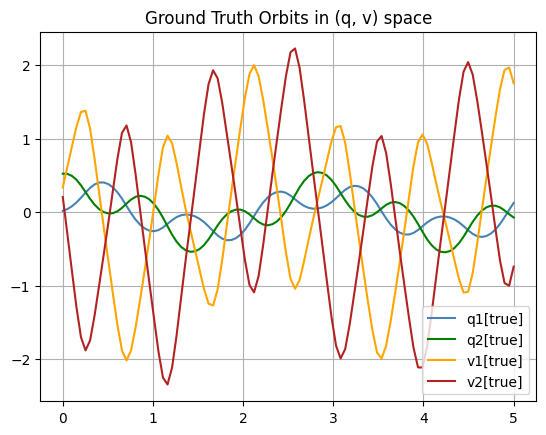

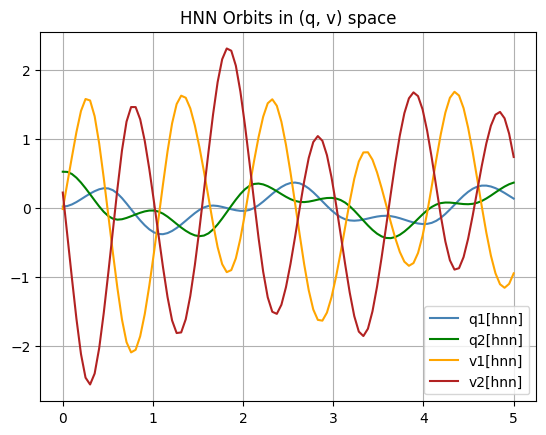

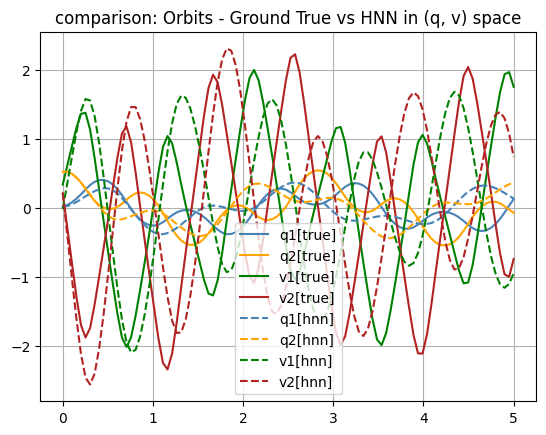

In [18]:
qt1, q2t, vt1, vt2 =convert_qp_to_qv(hnn_x_qp[:,0], hnn_x_qp[:,1], hnn_x_qp[:,2], hnn_x_qp[:,3], m1, m2, l1, l2)
hnn_x_qv = np.vstack([qt1, q2t, vt1, vt2]).T  # (M, 4) [q1, q2, v1, v2]

plt.title("Ground Truth Orbits in (q, v) space")
plt.plot(tval, true_x_qv[:,0], 'steelblue', label='q1[true]', linestyle='-')
plt.plot(tval, true_x_qv[:,1], 'g', label='q2[true]', linestyle='-')
plt.plot(tval, true_x_qv[:,2], 'orange', label='v1[true]', linestyle='-')
plt.plot(tval, true_x_qv[:,3], 'firebrick', label='v2[true]', linestyle='-')
plt.grid(True)
plt.legend()
plt.show()

plt.title("HNN Orbits in (q, v) space")
plt.plot(tval, hnn_x_qv[:,0], 'steelblue', label='q1[hnn]', linestyle='-')
plt.plot(tval, hnn_x_qv[:,1], 'g', label='q2[hnn]', linestyle='-')
plt.plot(tval, hnn_x_qv[:,2], 'orange', label='v1[hnn]', linestyle='-')
plt.plot(tval, hnn_x_qv[:,3], 'firebrick', label='v2[hnn]',linestyle='-')
plt.grid(True)
plt.legend()
plt.show()

plt.title("comparison: Orbits - Ground True vs HNN in (q, v) space")
plt.plot(tval, true_x_qv[:,0], 'steelblue', label='q1[true]', linestyle='-')
plt.plot(tval, true_x_qv[:,1], 'orange', label='q2[true]', linestyle='-')
plt.plot(tval, true_x_qv[:,2], 'g', label='v1[true]', linestyle='-') 
plt.plot(tval, true_x_qv[:,3], 'firebrick', label='v2[true]', linestyle='-')
plt.plot(tval, hnn_x_qv[:,0], 'steelblue', label='q1[hnn]', linestyle='--')
plt.plot(tval, hnn_x_qv[:,1], 'orange', label='q2[hnn]', linestyle='--')
plt.plot(tval, hnn_x_qv[:,2], 'g', label='v1[hnn]', linestyle='--')
plt.plot(tval, hnn_x_qv[:,3], 'firebrick', label='v2[hnn]',linestyle='--')
plt.grid(True)
plt.legend()
plt.show()